In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from pyDOE import lhs   # Latin Hypercube Sampling

## Damped Harmonic Oscillator

$$m\frac{d^2 u}{dt^2} + \mu\frac{du}{dt} + ku = 0$$
$$u(0) = 1,\quad u'(0) = 0$$

### Training Points - Sampling

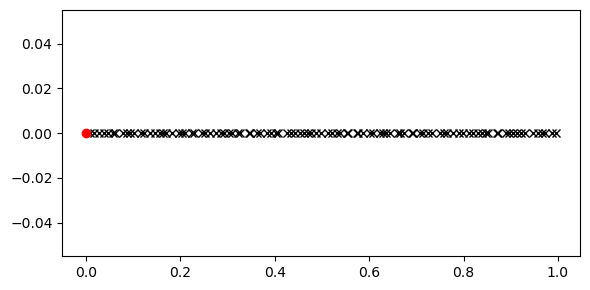

In [2]:
def u_exact(t, d=2, w0=20):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    return 2*A * np.cos(phi + w*t) * np.exp(-d*t)

n_points = 101

# Collocation points: t in (0, 1)
torch.manual_seed(0)
t = lhs(1, samples=n_points)    # Latin Hypercube Sampling

# Initial Conditions: u(0) = 1, u'(0) = 0
t_ic = np.array([0.0])
u_ic = np.array([1.0])
du_ic = np.array([0.0])

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(t, np.zeros_like(t), 'kx', label='Collocation points')
ax.plot(t_ic, np.zeros_like(t_ic), 'ro', label='Initial condition: u(0) = 1')
fig.tight_layout()
plt.show()

### Modeling

In [3]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),  nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1),
        )

    def forward(self, x):
        return self.layers(x)

# dy/dx using autograd
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

# u_tt + mu*u_t + k*u = 0
def loss_pde(model, t, mu, k):
    t.requires_grad = True
    u = model(t)
    u_t = gradient(u, t)
    u_tt = gradient(u_t, t)
    return torch.mean((u_tt + mu*u_t + k*u)**2)

# u_t(0) = 0
def loss_ic1(model, t, du_ic):
    t.requires_grad = True
    u = model(t)
    du = gradient(u, t)
    return torch.mean((du - du_ic)**2)

# u(0) = 1
def loss_ic2(model, t, u_ic):
    u = model(t)
    return torch.mean((u - u_ic)**2)

# np.ndarray to torch tensor
def tensor(x):
    return torch.tensor(x).float().view(-1, 1)

### Training

In [4]:
# Hyperparameters
d, w0 = 2, 20
mu, k = 2*d, w0**2
learning_rate = 1e-3
n_epochs = 20000

model = PINN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

losses = {}
for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    losses["pde"] = loss_pde(model, tensor(t), mu, k)
    losses["ic1"] = loss_ic1(model, tensor(t_ic), tensor(du_ic))
    losses["ic2"] = loss_ic2(model, tensor(t_ic), tensor(u_ic))
    loss = 1e-4 * losses["pde"] + 1e-2 * losses["ic1"] + losses["ic2"]

    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] "
              f"losses: {loss.item():.3e} (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"pde: {losses['pde'].item():.3e} "
              f"ic1: {losses['ic1'].item():.3e} "
              f"ic2: {losses['ic2'].item():.3e}")

[ 2000/20000] losses: 1.023e-02 (lr: 9.02e-04) pde: 1.000e+02 ic1: 1.257e-06 ic2: 2.301e-04
[ 4000/20000] losses: 8.949e-03 (lr: 8.15e-04) pde: 8.838e+01 ic1: 2.812e-07 ic2: 1.110e-04
[ 6000/20000] losses: 7.470e-03 (lr: 7.35e-04) pde: 7.387e+01 ic1: 6.929e-06 ic2: 8.369e-05
[ 8000/20000] losses: 2.893e-03 (lr: 6.63e-04) pde: 2.854e+01 ic1: 1.936e-05 ic2: 3.904e-05
[10000/20000] losses: 1.681e-03 (lr: 5.99e-04) pde: 1.671e+01 ic1: 1.242e-05 ic2: 1.046e-05
[12000/20000] losses: 9.370e-04 (lr: 5.40e-04) pde: 9.305e+00 ic1: 1.739e-08 ic2: 6.420e-06
[14000/20000] losses: 4.316e-04 (lr: 4.88e-04) pde: 4.293e+00 ic1: 9.496e-10 ic2: 2.297e-06
[16000/20000] losses: 3.436e-04 (lr: 4.40e-04) pde: 3.384e+00 ic1: 1.627e-04 ic2: 3.510e-06
[18000/20000] losses: 1.613e-04 (lr: 3.97e-04) pde: 1.609e+00 ic1: 2.173e-08 ic2: 4.048e-07
[20000/20000] losses: 1.196e-04 (lr: 3.58e-04) pde: 1.193e+00 ic1: 1.372e-09 ic2: 2.478e-07


### Evaluation

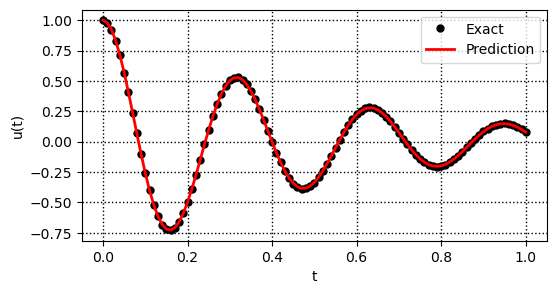

In [5]:
t_test = np.linspace(0, 1, 101)
with torch.no_grad():
    model.eval()
    u_pred = model(tensor(t_test))

# Plotting the results
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(t_test, u_exact(t_test), 'ko', label="Exact", ms=5)
ax.plot(t_test, u_pred, 'r', lw=2, label="Prediction")
ax.set(xlabel="t", ylabel="u(t)")
ax.grid(color="k", ls=":", lw=1)
ax.legend()
plt.show()